**Notas para contenedor de docker:**

Comando de docker para ejecución de la nota de forma local:

nota: cambiar `<ruta a mi directorio>` por la ruta de directorio que se desea mapear a `/datos` dentro del contenedor de docker.

```
docker run --rm -v <ruta a mi directorio>:/datos --name jupyterlab_r_kernel_local -p 8888:8888 -d palmoreck/jupyterlab_r_kernel:1.1.0
```

password para jupyterlab: `qwerty`

Detener el contenedor de docker:

```
docker stop jupyterlab_r_kernel_local
```


Documentación de la imagen de docker `palmoreck/jupyterlab_r_kernel:1.1.0` en [liga](https://github.com/palmoreck/dockerfiles/tree/master/jupyterlab/r_kernel).

---

Nota generada a partir de [liga](https://www.dropbox.com/s/6isby5h1e5f2yzs/4.2.Problemas_de_optimizacion_convexa.pdf?dl=0) 

In [1]:
install.packages(c("latex2exp","glmnet"),lib="/usr/local/lib/R/site-library/",
                repos="https://cran.itam.mx/")

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’




# Problema de clasificación

En esta nota revisamos a la **regresión logística con y sin regularización**. La **regularización** que utilizamos es la de **[Tikhonov](https://en.wikipedia.org/wiki/Tikhonov_regularization)** también nombrada $\ell_2$ o ***ridge*** y la $\ell_1$ o también conocida como **[*lasso*](https://en.wikipedia.org/wiki/Lasso_(statistics)** (*least absolute shrinkage and selection operator*, Tibshirani, 1996). Se muestra el uso de **métodos de descenso** (ver [4.2.Algoritmos_para_UCO](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/IV.optimizacion_convexa_y_machine_learning/4.2.Algoritmos_para_UCO.ipynb)) para resolver los problemas de optimización que surgen en los modelos anteriores y **no se tiene por objetivo la interpretación de los coeficientes estimados**. Se comparan los resultados del paquete  [glm](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/glm), [glmnet stanford](https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html), [glmnet cran](https://cran.r-project.org/web/packages/glmnet/index.html) de R con los obtenidos en la implementación hecha por el prof en [algoritmos/R](algoritmos/R), en específico [algoritmos/R/algorithms_for_uco.R](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/IV.optimizacion_convexa_y_machine_learning/algoritmos/R/algorithms_for_uco.R) para problemas tipo UCO (Unconstrained Convex Optimization). 

Sean $\mathcal{C}_0 , \mathcal{C}_1$ dos clases ajenas y $x \in \mathbb{R}^n$. El problema de clasificación consiste en clasificar al vector $x$ en alguna de las dos clases anteriores de modo que se minimice el error de clasificación.


Ejemplos de lo anterior los encontramos en medicina (persona enferma o no dada una serie de mediciones en sangre), finanzas (persona sujeta a un crédito bancario o no dado un historial crediticio) o clasificación de textos (*spam* o no *spam*).

En esta nota revisamos a la regresión logística que define un modelo de probabilidad de pertenenecia a una clase.

# Regresión logística: clasificación en $\mathcal{C}_0, \mathcal{C}_1$ 

In [1]:
library(ggplot2)
library(latex2exp)

El modelo por regresión logística tiene por objetivo **modelar las probabilidades de pertenencia a cada una de las clases** $\mathcal{C}_0, \mathcal{C}_1$ dado el vector de atributos $ x \in \mathbb{R}^n$: $p(\mathcal{C}_0|x) , p(\mathcal{C}_1|x)$.

En la regresión logística se utiliza la función **[sigmoide](https://en.wikipedia.org/wiki/Sigmoid_function)** $\sigma:\mathbb{R} \rightarrow \mathbb{R}$:

$$\sigma(t)=\frac{1}{1+\exp(-t)}$$

para modelar ambas probabilidades ya que mapea todo el eje real al intervalo $[0,1]$. Además resulta ser una aproximación continua y diferenciable a la función de **[Heaviside](https://en.wikipedia.org/wiki/Heaviside_step_function)** $H:\mathbb{R} \rightarrow \mathbb{R}$

$$H(t) = 
\begin{cases}
1 & \text{si } t \geq 0,\\
0 & \text{si } t <0\\
\end{cases}
$$



In [2]:
t <- seq(from = -10, to = 10, by = .01)

In [3]:
Heaviside <- function(t) 1*(t>0)

In [4]:
options(repr.plot.width=4, repr.plot.height=4) #esta línea sólo se ejecuta para jupyterlab con R

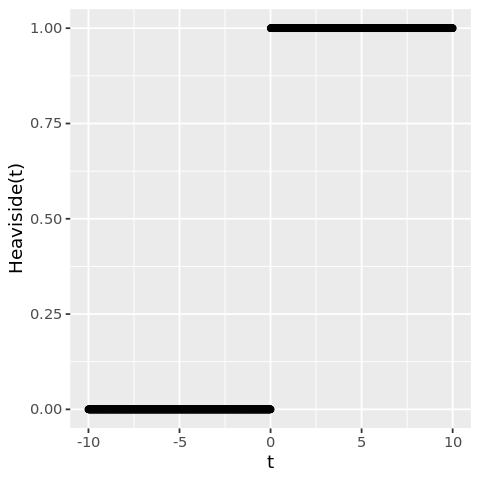

In [5]:
qplot(t, Heaviside(t))

In [6]:
options(repr.plot.width=7.5, repr.plot.height=7.5) #esta línea sólo se ejecuta para jupyterlab con R

A continuación graficamos a la sigmoide $\sigma(ht)$ para distintos valores de $h \in \{-3, -1, -1/2, 1/2, 1, 3\}$:

In [7]:
sigmoide <- function(t) 1/(1+exp(-t))

In [8]:
h<-c(-3,-1,-1/2,1/2,1,3)
h_reps <- as.vector(
                    vapply(1:length(h),function(i) rep(h[i], NROW(t)), 
                           numeric(length(t))
                           )
                    )
sigmoide_reps <- as.vector(
                           vapply(1:length(h), function(i) sigmoide(h[i]*t), 
                                  numeric(length(t))      
                                  )
                           )

In [9]:
df <- data.frame(x = rep(t, NROW(h)), 
                 y = sigmoide_reps, 
                 h = as.factor(h_reps)
                 )

In [10]:
gg <- ggplot(df)

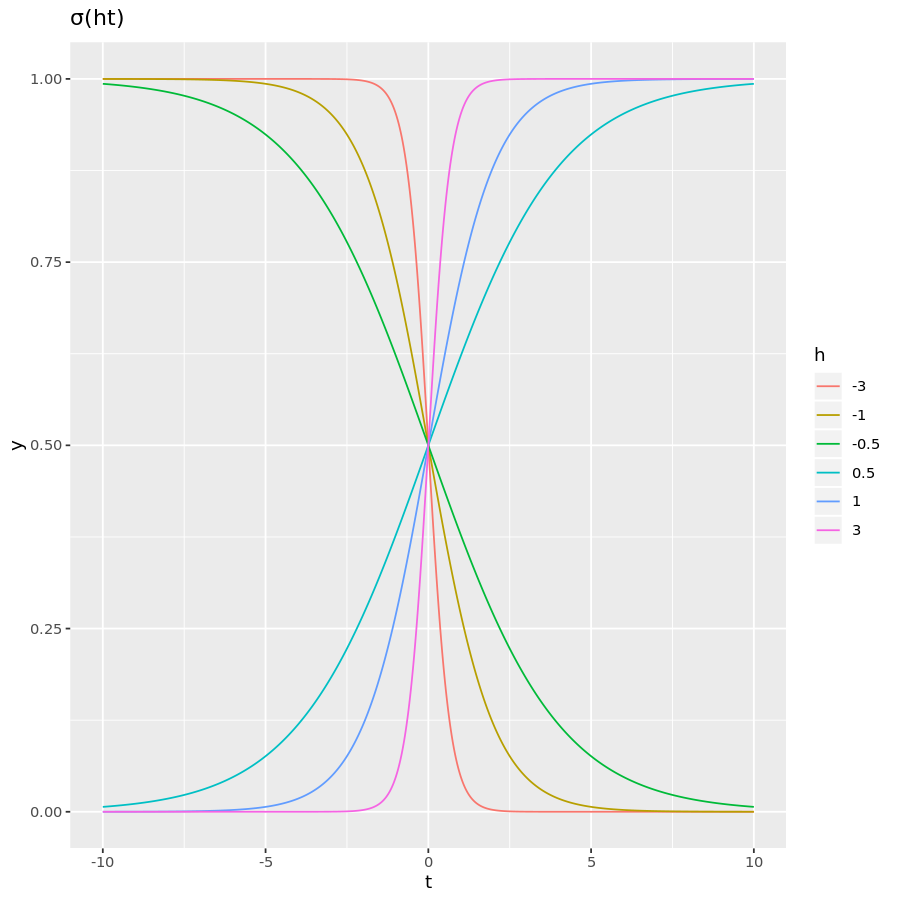

In [11]:
gg + geom_line(aes(x = x, y = y, group = h, color = h)) + 
   xlab('t') + 
   ggtitle(TeX('$\\sigma(ht)$'))

Obsérvese la forma de cada curva al variar $h$ en la función $\sigma(ht)$. Una regla de clasificación podría ser clasificar como perteneciente a $\mathcal{C}_0$ si la probabilidad (modelada por la curva sigmoide) es menor a $0.25$ (**punto de corte**) y perteneciente a $\mathcal{C}_1$ si es mayor o igual a $0.25$. Para diferentes curvas sigmoides presentadas en la gráfica anterior obsérvese que al fijar el punto de corte y tomar un valor de $t$ en el eje horizontal, la pertenencia a alguna de las clases es menos sensible al variar $t$ que en otras curvas.



Así, la función sigmoide permite modelar la probabilidad de pertenencia a la clase $\mathcal{C}_1:$

$$p(\mathcal{C}_1| x)=\sigma(a)$$

para alguna $a \in \mathbb{R}$.

Con el [teorema de Bayes](https://en.wikipedia.org/wiki/Bayes%27_theorem) se obtiene el valor de $a$:

$$
\begin{eqnarray}
p(\mathcal{C}_1|x) &=& \frac{p(x|\mathcal{C}_1)p(\mathcal{C}_1)}{p(x|\mathcal{C}_0)p(\mathcal{C}_0)+p(x|\mathcal{C}_1)p(\mathcal{C}_1)} \nonumber \\
&=& \left ( 1+ \frac{p(x|\mathcal{C}_0)p(\mathcal{C}_0)}{p(x|\mathcal{C}_1)p(\mathcal{C}_1)} \right )^{-1} \nonumber
\end{eqnarray}
$$

Por lo tanto:

$$
\begin{eqnarray}
a(x)&=&\log\left( \frac{p(x|\mathcal{C}_1)p(\mathcal{C}_1)}{p(x|\mathcal{C}_0)p(\mathcal{C}_0)} \right ) \nonumber
\end{eqnarray}
$$

**Comentarios:**

* Entre algunas propiedades que tiene la función $\sigma(\cdot)$ se encuentran:

$$
\begin{eqnarray}
\sigma (-t)&=&1-\sigma (t) \nonumber \\
\frac{d\sigma (t)}{dt}&=&\sigma (t)(1-\sigma (t)) \nonumber
\end{eqnarray}
$$


* En Estadística a la función:

$$a=\log\left(\frac{\sigma}{1-\sigma}\right)$$





se le conoce como [**logit**](https://en.wikipedia.org/wiki/Logit) y modela el log momio:



$$\log \left(\frac{p(\mathcal{C}_1|x)}{p(\mathcal{C}_0|x)}\right)=\log \left(\frac{p(\mathcal{C}_1|x)}{1-p(\mathcal{C}_1|x)}\right)$$

que tiene una interpretación directa en términos de las probabilidades de pertenencia a cada clase $\mathcal{C}_0,\mathcal{C}_1$.

# ¿Modelo en regresión logística de dos clases?

De forma similar como en el modelo por mínimos cuadrados lineales (ver [4.3.Minimos_cuadrados_R](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/IV.optimizacion_convexa_y_machine_learning/4.3.Minimos_cuadrados_R.ipynb)) se modeló a la variable respuesta $y$ con una función lineal en sus parámetros, en el modelo en regresión logística **con dos clases** se propone una función lineal en un vector de parámetros $(\beta_0,\beta) \in \mathbb{R}^{n+1}$ definida por el logit:

$$
\beta^T x+\beta_0=a(x|\beta_0,\beta)=\log \left(\frac{p(\mathcal{C}_1|x)}{p(\mathcal{C}_0|x)}\right).
$$


Obsérvese que si $y$ es considerada como variable respuesta que está en función de $x \in \mathbb{R}^{n+1}$ dado el vector $(\beta_0, \beta)$ se tiene:


$$p(\mathcal{C}_1 | x ) = y(x | \beta_0, \beta) = \frac{1}{1+ e^{-(\beta_0, \beta)^T x}}$$

que se lee "la probabilidad de pertenencia a la clase $\mathcal{C}_1$ dado el vector de atributos $x$ es igual a $y$".


**Comentarios:** 

* El modelo con $2$ parámetros $\beta_0, \beta_1$ se ve como:

$$p(\mathcal{C}_1 | x ) = y(x | \beta_0, \beta) = \frac{1}{1+ e^{-(\beta_0 + \beta_1x)}}$$


con $x \in \mathbb{R}$.



* El modelo puede extenderse utilizando $n+1$ funciones conocidas $\phi_j:\mathbb{R} \rightarrow \mathbb{R}$, $\phi_j(x)$ $j=0,\dots, n$ por lo que si $\phi(x)=(\phi_0(x),\phi_1(x),\dots,\phi_n(x))^T$ y $\beta_0 \in \mathbb{R}$, $\beta \in \mathbb{R}^n$, entonces se tiene el modelo por regresión logística:

$$
p(\mathcal{C}_1|\phi(x))=y(x|\beta_0, \beta)= \frac{1}{1+ e^{-(\beta_0, \beta)^T \phi(x)}}
$$

* La notación $y(x | \beta_0, \beta)$ se utiliza para denotar que $(\beta_0, \beta)$ es un vector de parámetros a estimar, en específico $\beta_0, \beta_1, \dots, \beta_n$, esto es: $n+1$ parámetros a estimar.

* La variable de optimización es $(\beta_0, \beta) \in \mathbb{R}^{n+1}$.

## ¿Cómo se ajustan los parámetros del modelo por regresión logística de dos clases?

Dados $(x_0,\hat{y}_0), \dots (x_m, \hat{y}_m)$ puntos se desean modelar $m+1$ probabilidades de pertenencias a las clases $\mathcal{C}_0, \mathcal{C}_1$ representadas con las etiquetas  $\hat{y}_i \in \{0,1\} \forall i=0,1,\dots, m$. El número $0$ representa a la clase $\mathcal{C}_0$ y el $1$ a la clase $\mathcal{C}_1$. El vector $x_i \in \mathbb{R}^n$ .

Cada probabilidad se modela como $y_0=y_0(x_0|\beta_0, \beta),y_1=y_1(x_1|\beta_0, \beta),\dots,y_m=y_m(x_n|\beta_0, \beta)$ utilizando:

$$p(\mathcal{C}_1|x_i) = y_i(x_i|\beta_0,\beta)  = \frac{1}{1+ e^{-(\beta_0 + \beta^T x)}} \forall i=0,1,\dots,m.$$


Los $n+1$ parámetros $\beta_0, \beta_1, \dots, \beta_n$ se ajustan **maximizando** la [función de verosimilitud](https://en.wikipedia.org/wiki/Likelihood_function):

$$
\mathcal{L}(\beta_0, \beta|x)=\displaystyle \prod_{i=0}^n y_i^{\hat{y}_i}(1-y_i)^{1-\hat{y}_i}
$$

donde: $\hat{y}_i \sim \text{Bernoulli}(y_i)$ y por tanto $\hat{y}_i \in \{0,1\}$: $\hat{y}_i = 1$ con probabilidad $y_i$ y $\hat{y}_i = 0$ con probabilidad $1-y_i$. Entonces se tiene el problema:



$$\displaystyle \max_{(\beta_0, \beta) \in \mathbb{R}^{n+1}} \mathcal{L}(\beta_0, \beta|x)=\displaystyle \prod_{i=0}^n y_i^{\hat{y}_i}(1-y_i)^{1-\hat{y}_i}$$

Lo anterior es equivalente a maximizar la log-verosimilitud:

$$
\begin{eqnarray}
\ell(\beta_0, \beta |x)&=&\log(\mathcal{L}(\beta_0, \beta| x)) \nonumber\\
&=&\displaystyle \sum_{i=1}^m \hat{y}_i\log(y_i)+(1-\hat{y}_i)\log(1-y_i) \nonumber\\
&=&\displaystyle \sum_{i=1}^m\hat{y}_i (\beta_0, \beta)^T x_i-\log(1+\exp((\beta_0, \beta)^Tx_i) \nonumber
\end{eqnarray}
$$

o a minimizar la [**devianza**](https://en.wikipedia.org/wiki/Deviance_(statistics):


$$
\begin{eqnarray}
\displaystyle \min_{(\beta_0, \beta) \in \mathbb{R}^{n+1}}\mathcal{D}(\beta_0, \beta|x)&=&-2\ell(\beta_0, \beta|x) \nonumber \\
&=&2\displaystyle \sum_{i=1}^m\log(1+\exp((\beta_0, \beta)^Tx_i))-\hat{y}_i(\beta_0, \beta)^Tx_i \nonumber
\end{eqnarray}
$$

**Comentario:**

La devianza es una función convexa pues su Hessiana\* es:

$$
\nabla^2 D(\beta_0, \beta |x) = 2A^TPA
$$

con: $P$ una matriz diagonal con entradas $y_i(1-y_i)$ donde: $y_i$ está en función de $x_i$: $ y_i(x_i|\beta_0,\beta) = \frac{1}{1+ e^{-(\beta_0 + \beta^T x_i)}} \forall i=0,1,\dots,m $ y la matriz A es:


$$A = \left[\begin{array}{c}
x_0\\
x_1\\
\vdots\\
x_m
\end{array}
\right]=\left[\begin{array}{cccc}
x_{01} & x_{02}&\dots& x_{0n}\\
x_{11}& x_{12}&\dots& x_{1n}\\
\vdots &\vdots& \vdots&\vdots\\
x_{n1} &x_{n2}&\dots&x_{nn}\\
\vdots &\vdots& \vdots&\vdots\\
x_{m1} &x_{m2}&\dots&x_{mn}
\end{array}
\right] \in \mathbb{R}^{(m+1)x(n+1)}
$$

\*La expresión anterior de la Hessiana se obtiene a partir de la expresión del gradiente:

$$
\nabla D(\beta_0, \beta|x) = 2 \displaystyle \sum_{i=1}^m \left( y_i - \hat{y}_i \right )x_i  = 2\sum_{i=1}^m \left( p(\mathcal{C}_1|x_i) - \hat{y}_i \right )x_i = 2A^T(p-\hat{y})
$$

donde:

$$
p=\left[\begin{array}{c}
y_0(x_0|\beta_0,\beta)\\
y_1(x_1|\beta_0,\beta)\\
\vdots \\
y_m(x_m|\beta_0,\beta)
\end{array}
\right]=
\left[\begin{array}{c}
p(\mathcal{C}_1|x_0)\\
p(\mathcal{C}_1|x_1)\\
\vdots \\
p(\mathcal{C}_1|x_m)
\end{array}
\right] \in \mathbb{R}^{n+1},
\hat{y}=
\left[\begin{array}{c}
\hat{y}_0\\
\hat{y}_1\\
\vdots \\
\hat{y}_m
\end{array}
\right] \in \mathbb{R}^{m+1}
$$


Así, la Hessiana de la devianza es simétrica semidefinida positiva y por tanto es una función convexa.  Ver el apéndice de definiciones para funciones convexas de [4.1.Optimizacion_numerica_y_machine_learning](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/IV.optimizacion_convexa_y_machine_learning/4.1.Optimizacion_numerica_y_machine_learning.ipynb).

Por lo anterior podemos utilizar los **métodos de descenso** para resolver **problemas de optimización convexa sin restricciones** revisados en la nota [4.2.Algoritmos_para_UCO](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/IV.optimizacion_convexa_y_machine_learning/4.2.Algoritmos_para_UCO.ipynb).

## Ejemplos

Como primer ejemplo utilizamos el conocido *dataset* de [*Iris*](https://en.wikipedia.org/wiki/Iris_flower_data_set) en el que se muestran tres especies del género *Iris*. Las especies son: [*I. setosa*](https://en.wikipedia.org/wiki/Iris_setosa), [*I. virginica*](https://en.wikipedia.org/wiki/Iris_virginica) y [*I. versicolor*](https://en.wikipedia.org/wiki/Iris_versicolor):


<img src="https://dl.dropboxusercontent.com/s/1bvsv79h0h64ijv/iris_dataset_flowers.png?dl=0" heigth="400" width="400">

Imagen obtenida de [Iris Dataset](https://rpubs.com/AjinkyaUC/Iris_DataSet).

In [12]:
library(datasets)
library(dplyr)
library(glmnet)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix

Loaded glmnet 4.0



In [13]:
data(iris)
summary(iris)


  Sepal.Length    Sepal.Width     Petal.Length    Petal.Width   
 Min.   :4.300   Min.   :2.000   Min.   :1.000   Min.   :0.100  
 1st Qu.:5.100   1st Qu.:2.800   1st Qu.:1.600   1st Qu.:0.300  
 Median :5.800   Median :3.000   Median :4.350   Median :1.300  
 Mean   :5.843   Mean   :3.057   Mean   :3.758   Mean   :1.199  
 3rd Qu.:6.400   3rd Qu.:3.300   3rd Qu.:5.100   3rd Qu.:1.800  
 Max.   :7.900   Max.   :4.400   Max.   :6.900   Max.   :2.500  
       Species  
 setosa    :50  
 versicolor:50  
 virginica :50  
                
                
                

In [14]:
print("Número de renglones y columnas:")
nrow(iris)
ncol(iris)

[1] "Número de renglones y columnas:"


[1] 150

[1] 5

**Para el modelo de regresión logística en dos clases utilizamos a la clase virginica y versicolor.**

In [15]:
iris_subset <- filter(iris, Species %in% c("virginica", "versicolor"))


In [16]:
head(iris_subset)

Sepal.Length Sepal.Width Petal.Length Petal.Width Species   
1 7.0          3.2         4.7          1.4         versicolor
2 6.4          3.2         4.5          1.5         versicolor
3 6.9          3.1         4.9          1.5         versicolor
4 5.5          2.3         4.0          1.3         versicolor
5 6.5          2.8         4.6          1.5         versicolor
6 5.7          2.8         4.5          1.3         versicolor

In [17]:
nrow(iris_subset)


[1] 100

**Obsérvese que la variable `Sepal.Length` y `Petal.Length` están altamente correlacionadas por lo que quitaremos a `Petal.length`:**

In [21]:
cor(as.matrix(iris_subset[,-ncol(iris_subset)]))

Sepal.Length Sepal.Width Petal.Length Petal.Width
Sepal.Length 1.0000000    0.5538548   0.8284787    0.5937094  
Sepal.Width  0.5538548    1.0000000   0.5198023    0.5662025  
Petal.Length 0.8284787    0.5198023   1.0000000    0.8233476  
Petal.Width  0.5937094    0.5662025   0.8233476    1.0000000

In [22]:
A<-iris_subset[,-c(3,ncol(iris_subset))]

In [23]:
head(A)

Sepal.Length Sepal.Width Petal.Width
1 7.0          3.2         1.4        
2 6.4          3.2         1.5        
3 6.9          3.1         1.5        
4 5.5          2.3         1.3        
5 6.5          2.8         1.5        
6 5.7          2.8         1.3

La variable $\hat{y}$ estará dada por las clases `versicolor` y `virginica`:

In [24]:
head(iris_subset[,ncol(iris_subset)])

[1] versicolor versicolor versicolor versicolor versicolor versicolor
Levels: setosa versicolor virginica

In [25]:
tail(iris_subset[,ncol(iris_subset)])

[1] virginica virginica virginica virginica virginica virginica
Levels: setosa versicolor virginica

**Transformamos a tipo numérica la columna `Species`:**

In [26]:
iris_subset$Clase <- as.numeric(iris_subset$Species %in% 'versicolor')

In [27]:
head(iris_subset)

Sepal.Length Sepal.Width Petal.Length Petal.Width Species    Clase
1 7.0          3.2         4.7          1.4         versicolor 1    
2 6.4          3.2         4.5          1.5         versicolor 1    
3 6.9          3.1         4.9          1.5         versicolor 1    
4 5.5          2.3         4.0          1.3         versicolor 1    
5 6.5          2.8         4.6          1.5         versicolor 1    
6 5.7          2.8         4.5          1.3         versicolor 1

In [28]:
tail(iris_subset)

Sepal.Length Sepal.Width Petal.Length Petal.Width Species   Clase
95  6.7          3.3         5.7          2.5         virginica 0    
96  6.7          3.0         5.2          2.3         virginica 0    
97  6.3          2.5         5.0          1.9         virginica 0    
98  6.5          3.0         5.2          2.0         virginica 0    
99  6.2          3.4         5.4          2.3         virginica 0    
100 5.9          3.0         5.1          1.8         virginica 0

La clase $\mathcal{C}_1$ es `versicolor` y $\mathcal{C}_0$ es `virginica`.

**Utilizamos el paquete la función [glm](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/glm) del paquete  [stats](https://www.rdocumentation.org/packages/stats/versions/3.6.2) para realizar el ajuste:**

In [29]:
glm.out <- glm(Clase ~ Sepal.Length + Sepal.Width  + Petal.Width,
               data = iris_subset,family = binomial)


In [30]:
summary(glm.out)


Call:
glm(formula = Clase ~ Sepal.Length + Sepal.Width + Petal.Width, 
    family = binomial, data = iris_subset)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.32596  -0.06825   0.00435   0.12171   1.62754  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)    20.287      8.055   2.519   0.0118 *  
Sepal.Length   -1.295      1.089  -1.189   0.2344    
Sepal.Width     4.823      2.097   2.300   0.0214 *  
Petal.Width   -15.923      3.981  -4.000 6.33e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 138.629  on 99  degrees of freedom
Residual deviance:  25.902  on 96  degrees of freedom
AIC: 33.902

Number of Fisher Scoring iterations: 8


Y nos interesan las estimaciones de los coeficientes $\beta_0, \beta_1, \beta_2, \beta_3$:

In [31]:
print(glm.out$coefficients)

 (Intercept) Sepal.Length  Sepal.Width  Petal.Width 
   20.287329    -1.295129     4.823274   -15.922660 


## Estimación vía método descenso con la dirección de Newton

La función objetivo como se revisó en la sección anterior está dada por la expresión de la devianza:

$$\mathcal{D}(\beta_0, \beta|x)=-2\ell(\beta_0, \beta|x) = 2\displaystyle \sum_{i=1}^m\log(1+\exp((\beta_0, \beta)^Tx_i))-\hat{y}_i(\beta_0, \beta)^Tx_i$$

donde: $\hat{y}_i \in \{0,1\}$, $x_i$ $i$-ésimo renglón de matriz $A \in \mathbb{R}^{100 \times 3}$.

**Añadimos la columna que indica uso de intercepto y por tanto de un modelo con $\beta_0$:**

In [32]:
A<-cbind(rep(1,nrow(A)),A)

In [33]:
head(A)

rep(1, nrow(A)) Sepal.Length Sepal.Width Petal.Width
1 1               7.0          3.2         1.4        
2 1               6.4          3.2         1.5        
3 1               6.9          3.1         1.5        
4 1               5.5          2.3         1.3        
5 1               6.5          2.8         1.5        
6 1               5.7          2.8         1.3

In [34]:
y_hat <- iris_subset$Clase

La clase $\mathcal{C}_1$ es `versicolor`:

In [35]:
head(y_hat)

[1] 1 1 1 1 1 1

La clase $\mathcal{C}_0$ es `virginica`:

In [36]:
tail(y_hat)

[1] 0 0 0 0 0 0

**Cargamos las funciones programadas en el directorio `algoritmos/R`:**

In [37]:
#load numerical differentiation
#load utils
#load algorithms for unconstrained convex optimization
#load line search
dir_R="algoritmos/R"
source(paste(dir_R,"/numerical_differentiation.R", 
             sep=""))
source(paste(dir_R,"/utils.R", 
             sep=""))
source(paste(dir_R,"/algorithms_for_uco.R", 
             sep=""))
source(paste(dir_R,"/line_search.R",
             sep=""))

**Convertimos a tipo matriz:**

In [38]:
A<-as.matrix(A)

In [39]:
head(A)

rep(1, nrow(A)) Sepal.Length Sepal.Width Petal.Width
[1,] 1               7.0          3.2         1.4        
[2,] 1               6.4          3.2         1.5        
[3,] 1               6.9          3.1         1.5        
[4,] 1               5.5          2.3         1.3        
[5,] 1               6.5          2.8         1.5        
[6,] 1               5.7          2.8         1.3

**Función objetivo:**

$$2\displaystyle \sum_{i=1}^m\log(1+\exp((\beta_0, \beta)^Tx_i))-\hat{y}_i(\beta_0, \beta)^Tx_i$$

In [40]:
fo <- function(beta){
    mat_vec <- A%*%beta
    2*sum(log(1+exp(mat_vec))-y_hat*mat_vec)
    }

**Punto inicial $\beta ^{(0)}:$**

In [41]:
beta_0 <- c(1,1,1,1)

**$\beta^*$:**

In [42]:
beta_ast_glm <- glm.out$coefficients


In [43]:
print(beta_ast_glm)

 (Intercept) Sepal.Length  Sepal.Width  Petal.Width 
   20.287329    -1.295129     4.823274   -15.922660 


In [44]:
p_ast <- fo(beta_ast_glm)

In [45]:
p_ast

[1] 25.90178

**Argumentos para el método de Newton:**


In [46]:
tol <- 1e-8
tol_backtracking <- 1e-14
maxiter <- 30

In [47]:
l<-Newtons_method(fo, beta_0, tol, tol_backtracking, beta_ast_glm, p_ast, maxiter)

I	Normgf	Newton Decrement	Error x_ast	Error p_ast	line search	condHf
1	7.57e+02	1.33e+06	9.91e-01	4.76e+01	---		4.05e+00
2	1.93e+02	2.84e+02	1.00e+00	6.17e+00	9.77e-04	7.05e+03
3	9.70e+01	2.56e+01	7.47e-01	9.50e-01	1.00e+00	5.79e+03
4	3.08e+01	1.03e+01	5.44e-01	3.24e-01	1.00e+00	7.18e+03
5	9.25e+00	2.78e+00	3.20e-01	7.82e-02	1.00e+00	7.50e+03
6	1.52e+00	3.78e-01	1.59e-01	1.23e-02	1.00e+00	6.27e+03
7	7.86e-02	1.84e-01	8.24e-02	2.68e-03	1.00e+00	1.69e+04
8	1.28e-01	1.01e-02	2.27e-02	2.97e-04	1.00e+00	7.21e+03
9	9.80e-03	1.25e-02	1.17e-02	5.03e-05	1.00e+00	6.71e+04
10	4.83e-03	7.50e-05	2.44e-03	2.31e-06	2.50e-01	8.13e+03
11	8.75e-04	-1.25e-04	9.96e-04	3.70e-07	1.00e+00	9.03e+04
Error of x with respect to x_ast: 9.96e-04
Approximate solution:[1]  20.262418  -1.292617   4.822189 -15.915167


In [48]:
beta <- l[[1]]
total_of_iterations <- l[[2]]
Err_plot <- l[[3]]
beta_plot <- l[[4]]


**Secuencia de minimización $\beta^{(k)}$:**

In [49]:
beta_plot

[,1] [,2]       [,3]       [,4]       [,5]        [,6]        [,7]      
[1,] 1     1.4294842  3.8175351  8.4249737  13.3470696  16.6217387  18.260357
[2,] 1    -0.2772908 -0.1623814 -0.4867251  -0.8016558  -0.9715607  -1.092434
[3,] 1    -0.9593097  2.3990819  2.9079099   3.6154886   4.3262240   4.678123
[4,] 1     1.4071470 -5.5800528 -8.2221512 -11.3714175 -14.0360939 -15.206825
     [,8]       [,9]       [,10]      [,11]     
[1,]  20.820428  20.576403  20.229388  20.262418
[2,]  -1.382637  -1.325532  -1.290058  -1.292617
[3,]   4.953561   4.842943   4.817441   4.822189
[4,] -16.137770 -16.017166 -15.896506 -15.915167

**$\beta$ aproximada por el método de Newton:**

In [50]:
print(beta)

[1]  20.262418  -1.292617   4.822189 -15.915167


**$\beta^*$:**

In [51]:
print(beta_ast_glm)

 (Intercept) Sepal.Length  Sepal.Width  Petal.Width 
   20.287329    -1.295129     4.823274   -15.922660 


In [52]:
compute_error(x_obj = beta_ast_glm,x_approx = beta)

[1] 0.0009957663

**Tenemos alrededor de 3 dígitos de precisión.**

**Comparemos con la función [glmnet](https://www.rdocumentation.org/packages/glmnet/versions/3.0-2/topics/glmnet) del paquete del mismo nombre (no usamos intercepto):**

In [54]:
fit<-glmnet(A[,-1],y_hat,family="binomial",alpha=0,lambda=0,standardize=F,nlambda=1, thresh=1e-8)


In [55]:
beta_ast_glmnet <- as.matrix(fit$beta)

In [56]:
print(beta_ast_glmnet)

                     s0
Sepal.Length  -1.295005
Sepal.Width    4.823018
Petal.Width  -15.922371


**Error relativo:**

In [57]:
compute_error(x_obj = beta_ast_glmnet,x_approx = beta[-1])

[1] 0.0004575515

**Tenemos alrededor de 3 dígitos de precisión.**

## Cálculo de probabilidades de pertenencia a las clases $\mathcal{C}_0 =$ `virginica`, $\mathcal{C}_1 =$ `versicolor`

**Para individuo $i$ se tiene:**

$$p(\mathcal{C}_1|x_i) = y_i(x_i|\beta_0,\beta)  = \frac{1}{1+ e^{-(\beta_0 + \beta^T x_i)}} \forall i=0,1,\dots,m.$$


**Por ejemplo para el renglón $1$ de $A$: (que sabemos que pertenece a la clase $\mathcal{C}_1$: `versicolor`):**

**Estimación de la probabilidad de pertenencia a la clase $\mathcal{C}_1$: `versicolor` con lo estimado por `glm`**:


In [58]:
1/(1+exp(-sum(A[1,]*beta_ast_glm)))

[1] 0.9874348

**Estimación de la probabilidad de pertenencia a la clase $\mathcal{C}_0$: `virginica` con lo estimado por `glm`**:


In [59]:
exp(-sum(A[1,]*beta_ast_glm))/(1+exp(-sum(A[1,]*beta_ast_glm)))

[1] 0.01256524

**Estimación de la probabilidad de pertenencia a la clase $\mathcal{C}_1$:`versicolor` con lo estimado por descenso por Newton**:


In [60]:
1/(1+exp(-sum(A[1,]*beta)))

[1] 0.987431

**Estimación de la probabilidad de pertenencia a la clase $\mathcal{C}_0$:`virginica` con lo estimado por descenso por Newton**:


In [61]:
exp(-sum(A[1,]*beta))/(1+exp(-sum(A[1,]*beta)))

[1] 0.01256904

**Por ejemplo para el último renglón de $A$: (que sabemos que pertenece a la clase $\mathcal{C}_0$: `virginica`):**

**Estimación de la probabilidad de pertenencia a la clase $\mathcal{C}_1$: `versicolor` con lo estimado por `glmn`**:


In [62]:
1/(1+exp(-sum(A[nrow(A),]*beta_ast_glm)))

[1] 0.175824

**Estimación de la probabilidad de pertenencia a la clase $\mathcal{C}_0$: `virginica` con lo estimado por `glmn`**:


In [63]:
exp(-sum(A[nrow(A),]*beta_ast_glm))/(1+exp(-sum(A[nrow(A),]*beta_ast_glm)))


[1] 0.824176

**Estimación de la probabilidad de pertenencia a la clase $\mathcal{C}_1$:`versicolor` con lo estimado por descenso por Newton**:


In [64]:
1/(1+exp(-sum(A[nrow(A),]*beta)))

[1] 0.175845

**Estimación de la probabilidad de pertenencia a la clase $\mathcal{C}_0$:`virginica` con lo estimado por descenso por Newton**:


In [65]:
exp(-sum(A[nrow(A),]*beta))/(1+exp(-sum(A[nrow(A),]*beta)))

[1] 0.824155

**A continuación consideramos regularización con ridge y lasso, ver [4.3.Minimos_cuadrados_R.ipynb](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/IV.optimizacion_convexa_y_machine_learning/4.3.Minimos_cuadrados_R.ipynb).**

# Regularización ridge con intercepto

In [66]:
reg<-0.5

In [67]:
fit<-glmnet(A,y_hat,family="binomial",alpha=0,lambda=reg,standardize=F,nlambda=1, thresh=1e-8)


**$\beta^*:$**

In [68]:
beta_ast<-as.matrix(fit$beta)

In [69]:
print(beta_ast)

                         s0
rep(1, nrow(A))  0.00000000
Sepal.Length    -0.24479206
Sepal.Width     -0.07182931
Petal.Width     -0.30070071


**Función objetivo de la función glmnet con regularización *ridge*:**

$$\frac{1}{m}\displaystyle \sum_{i=1}^m\log(1+\exp((\beta_0, \beta)^Tx_i))-\hat{y}_i(\beta_0, \beta)^Tx_i + \frac{\lambda}{2}||\beta||_2^2$$

In [70]:
mpoints<-nrow(A)

In [72]:
fo <-function(beta){
    mat_vec <- A %*% beta
    1/mpoints*(sum(log(1 + exp(mat_vec)) - y_hat * mat_vec)) + reg/2*sum(beta[2:length(beta)]*beta[2:length(beta)])
    }

**Punto inicial $\beta ^{(0)}:$**

In [73]:
beta_0 <- c(0,0,0,0)

In [74]:
p_ast <- fo(beta_ast)

In [75]:
p_ast

[1] 1.168373

In [76]:
tol <- 1e-12
tol_backtracking <- 1e-14
maxiter <- 30


In [77]:
l<-Newtons_method(fo, beta_0, tol, tol_backtracking, beta_ast, p_ast, maxiter)

I	Normgf	Newton Decrement	Error x_ast	Error p_ast	line search	condHf
1	2.45e-01	9.60e-02	1.00e+00	4.07e-01	---		1.14e+03
2	1.43e-03	3.95e-07	5.68e+00	4.48e-01	1.00e+00	1.13e+03
3	6.14e-07	1.79e-12	5.69e+00	4.48e-01	1.00e+00	1.14e+03
Error of x with respect to x_ast: 5.69e+00
Approximate solution:[1]  2.24298485 -0.24479077 -0.07182857 -0.30070082


In [78]:
beta <- l[[1]]
total_of_iterations <- l[[2]]
Err_plot <- l[[3]]
beta_plot <- l[[4]]


**$\beta$ aproximada por el método de Newton:**

In [79]:
print(beta)

[1]  2.24298485 -0.24479077 -0.07182857 -0.30070082


In [80]:
print(beta_ast)

                         s0
rep(1, nrow(A))  0.00000000
Sepal.Length    -0.24479206
Sepal.Width     -0.07182931
Petal.Width     -0.30070071


**Error relativo:**

In [81]:
compute_error(beta_ast[-1],beta[-1])

[1] 3.798396e-06

**Sin considerar el intercepto tenemos alrededor de $6$ dígitos de precisión.**

# Regularización Ridge sin intercepto

In [82]:
A<-A[,-1]

In [83]:
head(A)

Sepal.Length Sepal.Width Petal.Width
[1,] 7.0          3.2         1.4        
[2,] 6.4          3.2         1.5        
[3,] 6.9          3.1         1.5        
[4,] 5.5          2.3         1.3        
[5,] 6.5          2.8         1.5        
[6,] 5.7          2.8         1.3

**Solución con glmnet:**

In [84]:
fit<-glmnet(A,y_hat,family="binomial",alpha=0,lambda=reg,standardize=F,nlambda=1, intercept=F, thresh=1e-8)


In [85]:
beta_ast <- as.matrix(fit$beta)

**$\beta^*:$**

In [86]:
print(beta_ast)

                      s0
Sepal.Length  0.02157718
Sepal.Width   0.05710003
Petal.Width  -0.24262286


**Solución vía método de Newton:**

**Punto inicial $\beta ^{(0)}:$**

In [87]:
beta_0 <- c(0,0,0)

In [88]:
p_ast <- fo(beta_ast)

In [89]:
p_ast

[1] 0.6750204

In [90]:
tol <- 1e-12
tol_backtracking <- 1e-14
maxiter <- 30

In [91]:
fo <-function(beta){
    mat_vec <- A %*% beta
    1/mpoints*(sum(log(1 + exp(mat_vec)) - y_hat * mat_vec)) + reg/2*sum(beta*beta)
    }

In [92]:
l<-Newtons_method(fo, beta_0, tol, tol_backtracking, beta_ast, p_ast, maxiter)

I	Normgf	Newton Decrement	Error x_ast	Error p_ast	line search	condHf
1	2.45e-01	3.60e-02	1.00e+00	2.69e-02	---		2.55e+01
2	5.61e-04	2.53e-08	2.79e-04	1.72e-04	1.00e+00	2.54e+01
3	4.15e-08	1.97e-15	5.27e-05	1.72e-04	1.00e+00	2.54e+01
Error of x with respect to x_ast: 5.27e-05
Approximate solution:[1]  0.02157031  0.05711028 -0.24261826


In [93]:
beta <- l[[1]]
total_of_iterations <- l[[2]]
Err_plot <- l[[3]]
beta_plot <- l[[4]]


**$\beta$ aproximada por el método de Newton:**

In [94]:
print(beta)

[1]  0.02157031  0.05711028 -0.24261826


In [95]:
print(beta_ast)

                      s0
Sepal.Length  0.02157718
Sepal.Width   0.05710003
Petal.Width  -0.24262286


**Error relativo:**

In [96]:
compute_error(x_approx = beta, x_obj = beta_ast)

[1] 5.26635e-05

**Tenemos alrededor de $5$ dígitos de precisión.**

## Regularización lasso sin intercepto

**Función objetivo de la función glmnet con regularización *lasso*:**

$$\frac{1}{m}\displaystyle \sum_{i=1}^m\log(1+\exp((\beta_0, \beta)^Tx_i))-\hat{y}_i(\beta_0, \beta)^Tx_i + \lambda \alpha||\beta||_1$$

In [97]:
reg <- 0.01

**Solución vía `glmnet`:**

In [98]:
fit<-glmnet(A,y_hat,family="binomial",alpha=1,lambda=reg,standardize=F,nlambda=1, intercept=F, thresh=1e-8)


In [99]:
beta_ast <- as.matrix(fit$beta)

**$\beta^*:$**

In [100]:
print(beta_ast)

                     s0
Sepal.Length  0.6246049
Sepal.Width   3.0968033
Petal.Width  -7.8624767


**Solución vía método de Newton:**

Usaremos la siguiente función `quita_signo` que ayuda a aproximar la derivada de la función objetivo $f_o$ y así lidiar con la no diferenciabilidad en $0$.

La función `quita_signo` realiza:

$$\text{quita_signo}(x) = \begin{cases}
x & \text{si } x > 0,\\
-x & \text{si } x <0,\\
\approx 2.22 \times 10^{-308} & \text{si } |x| \approx 0
\end{cases}$$


**obsérvese que el valor elegido en el tercer caso es el más pequeño positivo normalizado en un sistema de punto flotante, ver [1.2.Sistema_de_punto_flotante](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.2.Sistema_de_punto_flotante.ipynb).**

In [101]:
quita_signo<-function(beta){
    beta<-sign(beta)*beta
    ind <- beta < .Machine$double.xmin & beta > -.Machine$double.xmin 
    beta[ind] <- .Machine$double.xmin 
    beta
    }

**Comentario:** la definición de la función `quita_signo` se basa en lo que se conoce como *subdifferential* que es un conjunto de [subderivatives](https://en.wikipedia.org/wiki/Subderivative), útiles para generalizar las derivadas para funciones convexas que no son diferenciables en puntos de su dominio.

In [103]:
fo <-function(beta){
    mat_vec <- A %*% beta
    1/mpoints*(sum(log(1 + exp(mat_vec)) - y_hat * mat_vec)) + reg*sum(quita_signo(beta))
    }

**Punto inicial $\beta ^{(0)}:$**

In [104]:
beta_0<-c(1,1,1)

In [105]:
l<-Newtons_method(fo, beta_0, tol, tol_backtracking, beta_ast, p_ast, maxiter)

I	Normgf	Newton Decrement	Error x_ast	Error p_ast	line search	condHf
1	3.77e+00	6.18e+03	1.08e+00	7.63e+00	---		5.41e+00
2	4.53e-01	2.39e-01	7.19e-01	2.57e-01	9.77e-04	7.90e+02
3	1.81e-01	4.24e-02	3.57e-01	4.57e-01	1.00e+00	8.36e+02
4	5.06e-02	4.76e-03	1.19e-01	4.93e-01	1.00e+00	1.09e+03
5	6.55e-03	7.16e-05	1.41e-02	4.97e-01	1.00e+00	1.21e+03
6	1.15e-04	7.11e-08	8.06e-04	4.97e-01	1.00e+00	1.24e+03
7	1.60e-07	6.13e-12	9.60e-04	4.97e-01	1.00e+00	1.27e+03
8	1.92e-08	1.35e-14	9.63e-04	4.97e-01	1.00e+00	1.26e+03
Error of x with respect to x_ast: 9.63e-04
Approximate solution:[1]  0.6222248  3.1038730 -7.8657876


In [106]:
beta <- l[[1]]
total_of_iterations <- l[[2]]
Err_plot <- l[[3]]
beta_plot <- l[[4]]


**$\beta$ aproximada por el método de Newton:**

In [107]:
print(beta)

[1]  0.6222248  3.1038730 -7.8657876


In [108]:
print(beta_ast)

                     s0
Sepal.Length  0.6246049
Sepal.Width   3.0968033
Petal.Width  -7.8624767


**Error relativo:**

In [109]:
compute_error(x_approx = beta, x_obj = beta_ast)

[1] 0.000963169

**Tenemos alrededor de 3 dígitos de precisión.**

**Referencias:**


* [Regularization Paths for Generalized Linear Models via Coordinate Descent](https://web.stanford.edu/~hastie/Papers/glmnet.pdf)
